In [9]:
import pandas as pd
import numpy as np 
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')

In [11]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [13]:
plt.figure(figsize = (10,10))
plt.subplots

<function matplotlib.pyplot.subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)>

<Figure size 720x720 with 0 Axes>

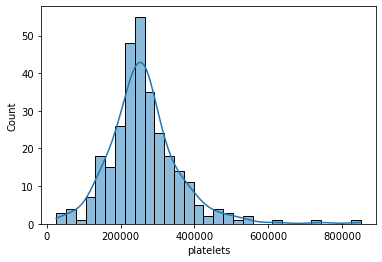

In [15]:
df.columns
sns.histplot(df['platelets'], kde = True)
plt.savefig('platelets.jpg')


C:\Users\personal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


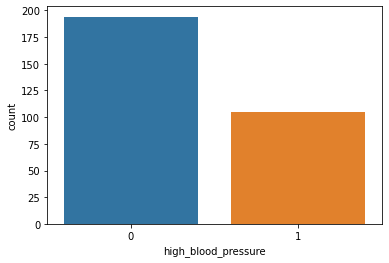

In [16]:
sns.countplot(df['high_blood_pressure'])
plt.savefig('hbp_c.jpg')

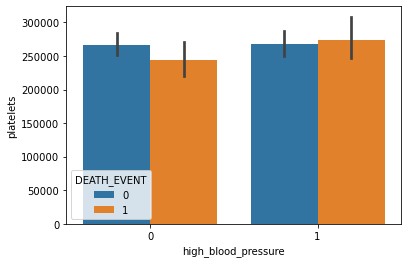

In [17]:
sns.barplot(x = 'high_blood_pressure', y = 'platelets', hue = 'DEATH_EVENT', data = df)
plt.savefig('hbp.jpg')

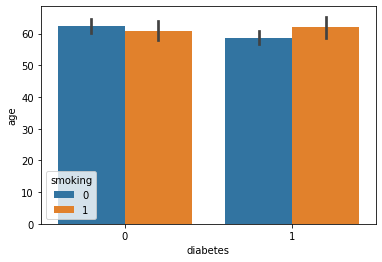

In [19]:
sns.barplot(x = 'diabetes', y = 'age', hue = 'smoking', data = df)
plt.savefig('dia_age_smo.jpg')

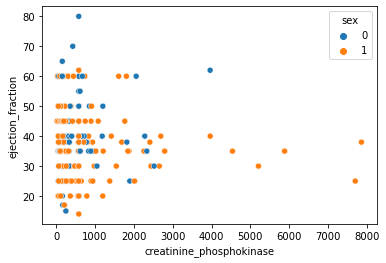

In [20]:
sns.scatterplot(x = 'creatinine_phosphokinase', y = 'ejection_fraction', hue ='sex', data = df)
plt.savefig('numerical.jpg')

#####
Appendix 1.2 Advanced Question 1 

In [22]:
from sklearn.decomposition import FactorAnalysis 
import matplotlib.pyplot as plt


In [25]:
FA = FactorAnalysis(n_components =2, rotation = 'varimax')
X_trf=FA.fit_transform(df.drop('DEATH_EVENT', axis = 1))

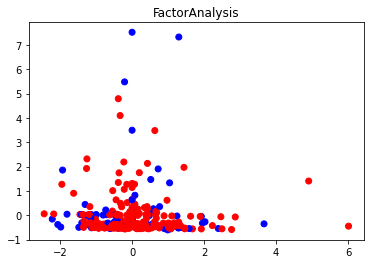

In [27]:
c_d = {1: "blue", 0:"red"}
plt.scatter(X_trf[:,0], X_trf[:,1], c = [c_d[i] for i in df['DEATH_EVENT']])
plt.title('FactorAnalysis')
plt.savefig('FA.jpg')

###
Appendix 1.3 Question 2 


In [31]:
class Dataset(data.Dataset):
    def __init__(self):
        train = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
        train_labels = train['DEATH_EVENT'].values
        train = train.drop("DEATH_EVENT",axis=1).values
        self.datalist = train
        self.labels = train_labels
        
    def __getitem__(self, index):
        return torch.Tensor(self.datalist[index].astype(float)), self.labels[index]
    def __len__(self):
        return self.datalist.shape[0]

In [32]:
ds = Dataset()
train_size = int(0.7 * len(ds))
test_size = len(ds) - train_size
train, val = torch.utils.data.random_split(ds, [train_size, test_size])

In [33]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12, 5)
        self.fc2 = nn.Linear(5, 3)
        self.fc3 = nn.Linear(3, 1)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x

In [34]:
model = Model()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [35]:
train_loader = torch.utils.data.DataLoader( dataset = train , batch_size= 32 , shuffle = True)
val_loader = torch.utils.data.DataLoader( dataset = val , batch_size= 8)


In [37]:
for epoch in range(200):
  run_train_loss = 0.0
  run_val_loss = 0.0
  running_acc = 0.0
  total_size = 0
  best_acc = 0
  for i, (feature, labels) in enumerate(train_loader):
      images = feature
      labels = torch.Tensor(np.array(labels).astype(float))
      
      optimizer.zero_grad()
      outputs = model(images)
      #print(outputs, labels)
      loss = criterion(outputs.T[0], labels.T)
      loss.backward()
      optimizer.step()
      run_train_loss += loss
  with torch.no_grad():
    model.eval()
    s = 0
    for j , (val_f, val_labels) in enumerate(val_loader):
      s += len(val_labels)
      val_labels = torch.Tensor(np.array(val_labels).astype(float))
      pred = model(val_f)
      running_acc += (pred.T[0] == val_labels).sum().item()
    print((running_acc / s) * 100)

71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.11111111111111
71.1111111

### 1.4 advanced question 2

In [38]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12, 24)
        self.fc2 = nn.Linear(24, 1)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        
        return x


In [39]:
modelex = Model()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [40]:
preds = []
val_l = []
for val_f, val_labels in val_loader:
  for la in val_labels:
    val_l.append(la.item())
  pred = model(val_f).T
  l = [i.item() for i in pred[0][:]]
  for p in l:
    preds.append(p)
print(accuracy_score(val_l, preds))

0.7111111111111111


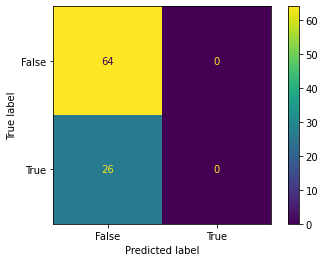

In [41]:
cm = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(val_l, preds), display_labels = [False, True])
cm.plot()
plt.savefig('cmstr.jpg')
plt.show()